 Task 3: Q-learning for mobile robot navigation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
### auxiliary functions
import pandas as pd


def action_decode(act_code):
    dirs = {0: "N", 1: "E", 2: "S", 3: "W"}
    return dirs[act_code]


def action_encode(act):
    dir_codes = {"N": 0, "E": 1, "S": 2, "W": 3}
    return dir_codes(act)


def display_learning(series, label):
    n_episodes = len(series)
    show_n = 20
    show_step = int(n_episodes / show_n)
    sequence = []
    for i in range(show_n):
        sequence.append(np.mean(series[show_step * i:show_step * (i + 1)]))
        print((i + 1) * show_step, ' episodes ', label, sequence[-1])
    print('\n')
    plt.figure()
    plt.plot(sequence)
    plt.ylabel(label)
    plt.xlabel('episodes')


def update_dataframe(df, result_steps, test_agent_steps, rewards, episodes, maze_height, maze_width, decay, start):
    """
    Update the data frame with a new row of data.
    """
    new_row = pd.DataFrame({'Result Steps': [result_steps],
                            'Test Result Steps': [test_agent_steps],
                            'Rewards': [rewards],
                            'Episodes': [episodes],
                            'Maze Height': [maze_height],
                            'Maze Width': [maze_width],
                            'Decay(Learning Rate)': [decay],
                            'Start': [start]
                            })
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [2]:
class grid_env():
    ### definition of the maze environment

    def __init__(self, width=5, height=5, start=[0, 0], debug=False):
        # Contructor methods create the environment with some given options
        self.width = width
        self.height = height
        self.start = start
        self.goal = [self.width - 1, self.height - 1]
        self.debug = debug
        self.n_states = self.width * self.height
        self.reset()

    def reset(self):
        # Reset method puts the state at the starting position
        self.pos = self.start[:]  # columns, rows
        return self.pos, 0, False

    def state_decode(self, obs_code):
        r = obs_code // self.width
        c = obs_code % self.width
        return ([c, r])

    def state_encode(self, position):
        code = position[0] + position[1] * (self.width)  # columns, rows
        return (code)

    def step(self, action):
        # Depending on the action, update the environment state
        if action == "S" and (self.pos[1] < self.height - 1):
            self.pos[1] += 1
        elif action == "N" and self.pos[1] > 0:
            self.pos[1] -= 1
        elif action == "W" and self.pos[0] > 0:
            self.pos[0] -= 1
        elif action == "E" and (self.pos[0] < self.width - 1):
            self.pos[0] += 1

        done = (self.pos == self.goal)  # check if goal was reached
        if done:
            reward = self.width + self.height  # reward at goal
        else:
            reward = -1  # negative reward at every step

        if self.debug:
            print(self.render())

        return self.pos, reward, done

    def render(self):
        res = ""
        for y in range(self.height):
            for x in range(self.width):
                if self.goal[0] == x and self.goal[1] == y:
                    if self.pos[0] == x and self.pos[1] == y:
                        res += "@"
                    else:
                        res += "o"
                    continue
                if self.pos[0] == x and self.pos[1] == y:
                    res += "x"
                else:
                    res += "_"
            res += "\n"
        return (res)

In [3]:
class agent():
    ### definition of the agent

    def __init__(self, n_obs, discount=1, learning_rate=0.1, eps={'start': 1, 'min': 0.01, 'decay': 0.001}):
        self.action_space = np.asarray([0, 1, 2, 3])  # north, east, south, west
        n_actions = np.shape(self.action_space)[0]
        self.Q_table = np.zeros((n_obs, n_actions))

        self.epsilon = eps['start']  #initialize the exploration probability to 1
        self.epsilon_decay = eps['decay']  #exploration decreasing decay for exponential decreasing
        self.epsilon_min = eps['min']  # minimum of exploration proba

        self.gamma = discount  #discounted factor
        self.alpha = learning_rate  #learning rate

    def action_selection(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.action_space[np.random.randint(0, 3)]  # choose a random action with probability epsilon
        else:
            action = np.argmax(self.Q_table[state, :])  # choose the best action for that state with prob 1-epsilon
        return (action)

    def policy_update(self, action, reward, state, next_state):
        self.Q_table[state, action] = (1 - self.alpha) * self.Q_table[state, action] + self.alpha * (
                reward + self.gamma * max(self.Q_table[next_state, :]))

    def decrease_exploration(self, e):
        self.epsilon = max(self.epsilon_min, np.exp(-self.epsilon_decay * e))

    def test_agent(self, env):
        state, _, done = env.reset()
        steps = 0
        while not done and steps < 100:
            action = ag.action_selection(env.state_encode(state))
            next_state, reward, done = env.step(action_decode(action))
            steps += 1
        print("Number of steps: ", steps)
        return steps

    def train(self, env, n_episodes=1000, max_steps=100):
        all_rewards = []
        all_steps = []
        for e in range(n_episodes):  # iterate over episodes
            state, _, done = env.reset()
            trial_reward = 0
            t = 0
            while not done and t < max_steps:
                action = ag.action_selection(env.state_encode(state))  # step 1: choose an action
                old_state = state[:]
                next_state, reward, done = env.step(action_decode(
                    action))  # steps 2 and 3: The environment runs the chosen action and returns next state and reward
                ag.policy_update(action, reward, env.state_encode(old_state),
                                 env.state_encode(next_state))  # step 4: policy update
                trial_reward += reward
                t += 1
            ag.decrease_exploration(e)
            all_rewards.append(trial_reward)
            all_steps.append(t)
        return (all_rewards, all_steps)

Task 3

A.	Modify the maze, changing size and shape, and different start positions. How many steps does it take to reach the target? Does the performance vary as you expect?

B.	Change the agent learning parameters (e.g. learning rate, discount factor, exploration values). How does performance change in terms of learning speed and ability to reach the target? What happens if exploration is always maximum? And if it decreases very quickly?

C. Optional. Change the reward applied to different types of actions and test the learning performance. Are you able to find values for which learning is even faster? Imagine that there was a hole in the maze: how can you make the agent learn to avoid it?

250  episodes  reward  -61.164
500  episodes  reward  -24.876
750  episodes  reward  -9.98
1000  episodes  reward  -5.952
1250  episodes  reward  -2.988
1500  episodes  reward  -1.616
1750  episodes  reward  0.104
2000  episodes  reward  0.832
2250  episodes  reward  1.376
2500  episodes  reward  1.728
2750  episodes  reward  1.784
3000  episodes  reward  2.336
3250  episodes  reward  2.492
3500  episodes  reward  2.612
3750  episodes  reward  2.636
4000  episodes  reward  2.692
4250  episodes  reward  2.708
4500  episodes  reward  2.872
4750  episodes  reward  2.888
5000  episodes  reward  2.904


250  episodes  steps  74.856
500  episodes  steps  45.12
750  episodes  steps  30.98
1000  episodes  steps  26.952
1250  episodes  steps  23.988
1500  episodes  steps  22.532
1750  episodes  steps  20.896
2000  episodes  steps  20.168
2250  episodes  steps  19.624
2500  episodes  steps  19.272
2750  episodes  steps  19.216
3000  episodes  steps  18.664
3250  episodes  steps  18.508
3500  epi

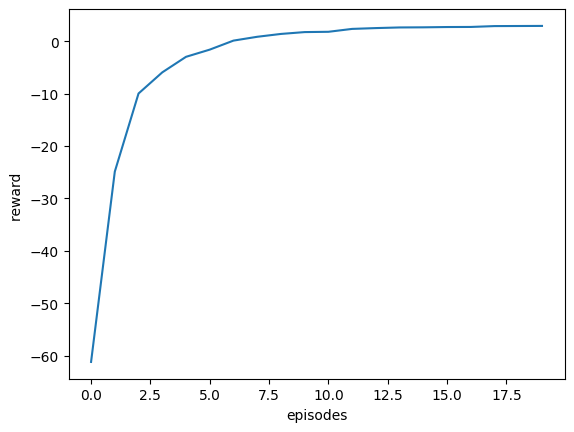

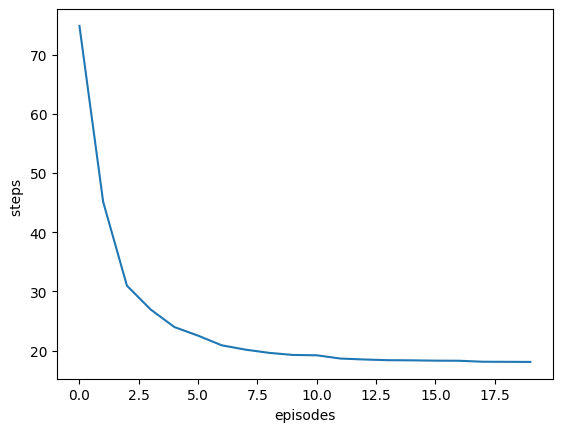

In [4]:
# this code is only an example, remove it or change it

maze_height = 10
maze_width = 10
start = [0, 0]
maze = grid_env(maze_height, maze_width, start)

decay = 0.001
epsilon = {'start': 1, 'min': 0.01, 'decay': decay}  # parameter epsilon needs to be a dictionary
ag = agent(maze.n_states,
           eps=epsilon)  # only one parameter is compulsory, try adding different values of discount factor and learing rate
episodes = 5000
steps = 100
[rewards, steps] = ag.train(maze, episodes, steps)

display_learning(rewards, "reward ")
display_learning(steps, "steps ")

print(ag.Q_table)

maze = grid_env(maze_height, maze_width, start, debug=True)
test_agent_steps = ag.test_agent(maze)
"Number of steps", test_agent_steps

df = pd.DataFrame({'Result Steps': [steps],
                   'Test Result Steps': [test_agent_steps],
                   'Rewards': [rewards],
                   'Episodes': [episodes],
                   'Maze Height': [maze_height],
                   'Maze Width': [maze_width],
                   'Decay(Learning Rate)': [decay],
                   'Start': [start]
                   })


250  episodes  reward  -53.12
500  episodes  reward  -23.568
750  episodes  reward  -9.904
1000  episodes  reward  -5.596
1250  episodes  reward  -3.184
1500  episodes  reward  -1.552
1750  episodes  reward  -0.3
2000  episodes  reward  0.728
2250  episodes  reward  1.42
2500  episodes  reward  1.58
2750  episodes  reward  2.036
3000  episodes  reward  2.056
3250  episodes  reward  2.384
3500  episodes  reward  2.484
3750  episodes  reward  2.696
4000  episodes  reward  2.748
4250  episodes  reward  2.772
4500  episodes  reward  2.772
4750  episodes  reward  2.86
5000  episodes  reward  2.82


250  episodes  steps  68.912
500  episodes  steps  43.98
750  episodes  steps  30.904
1000  episodes  steps  26.596
1250  episodes  steps  24.184
1500  episodes  steps  22.552
1750  episodes  steps  21.3
2000  episodes  steps  20.272
2250  episodes  steps  19.58
2500  episodes  steps  19.42
2750  episodes  steps  18.964
3000  episodes  steps  18.944
3250  episodes  steps  18.616
3500  episodes  s

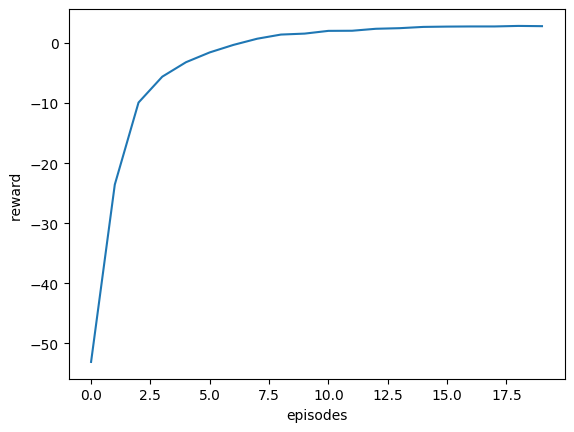

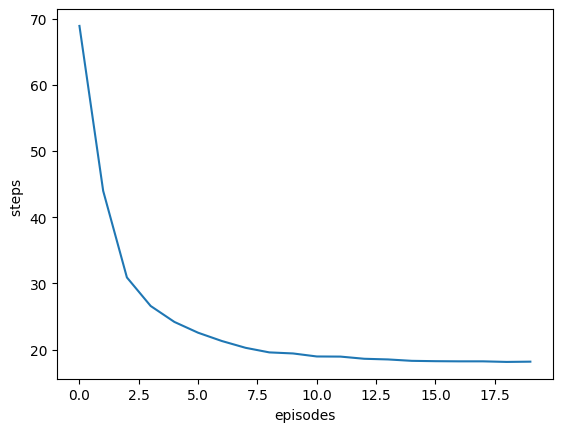

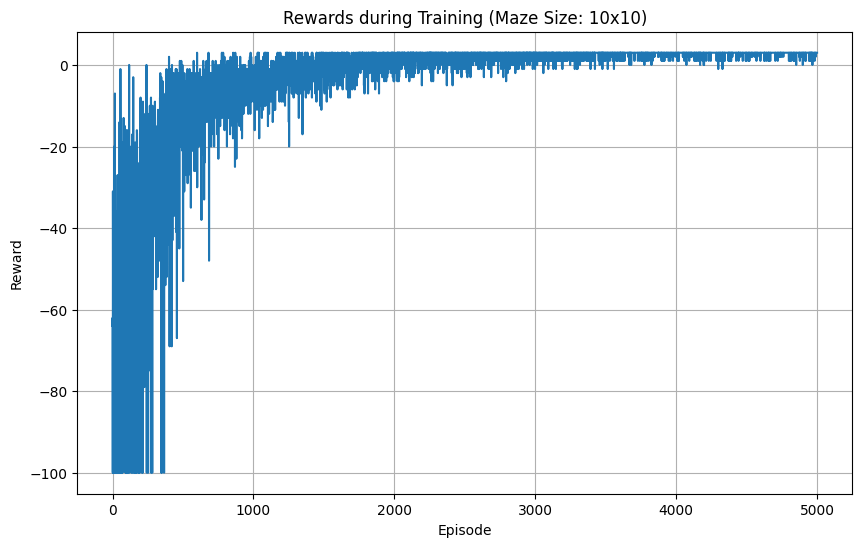

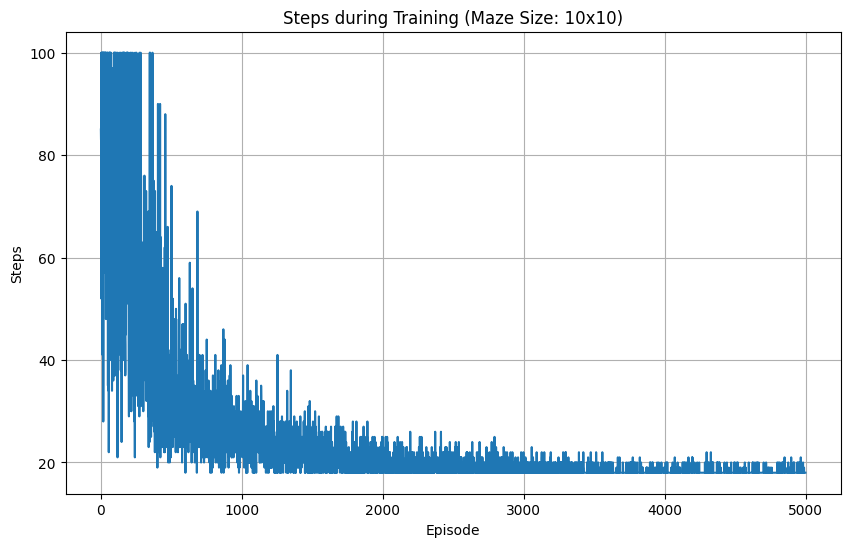

_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__x_______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__________
__x_______
__________
__________
__________
__________
__________
__________
__________
_________o

__________
___x______
__________
__________
__________
__________
__________
__________
__________
_________o

__________
____x_____
__________
__________
__________
__________
__________
__________
__________
_________o

__________
_____x____
__________
__________
__________
__________
__________
__________
__________
_________o

__________
______x___
__________
__________
__________
__________
__________
__________
__________
_________o

__________
_______x__
__________
__________
__________
__________
__________
__________
__________
_________o

__________
________x_
__________
__________
__________
__________
__________
__________
__________
_________o

_

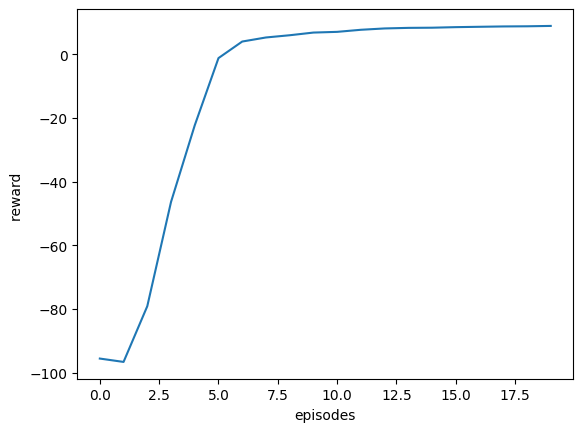

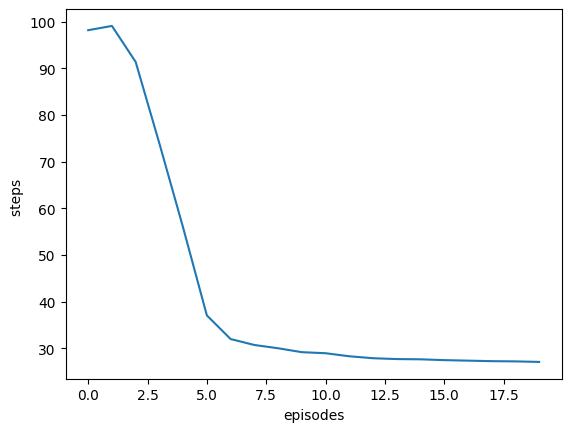

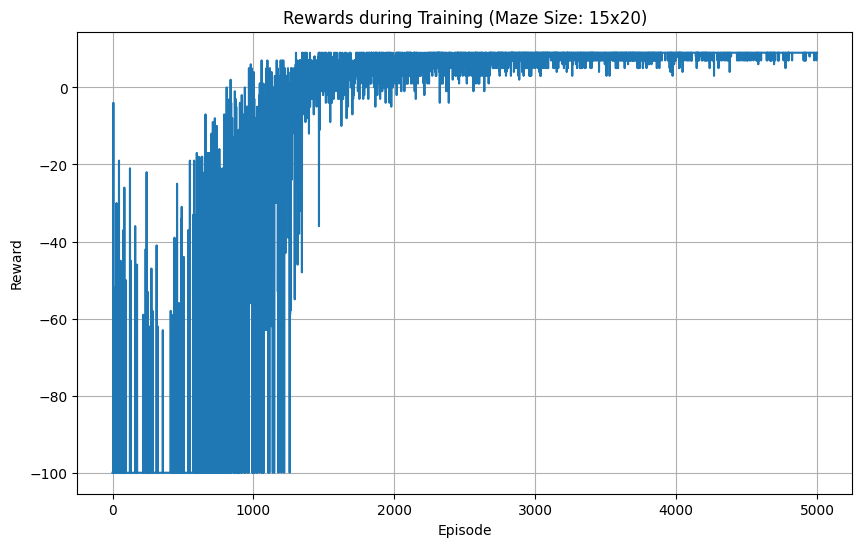

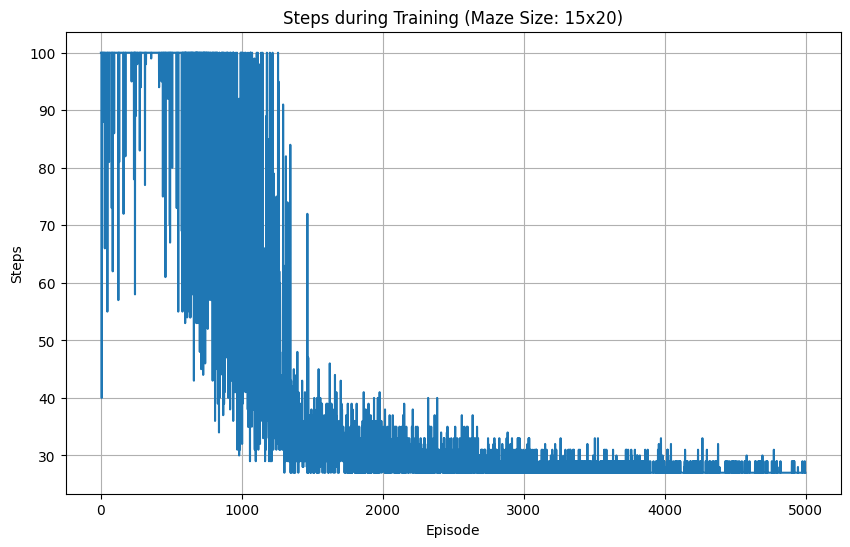

_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_____

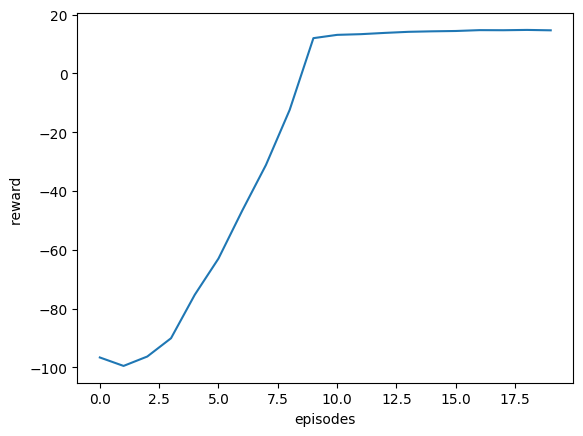

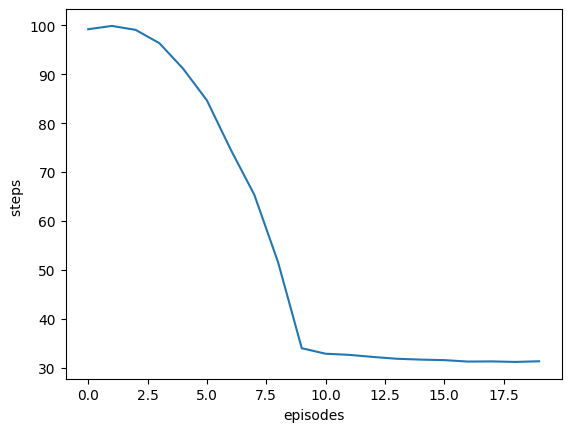

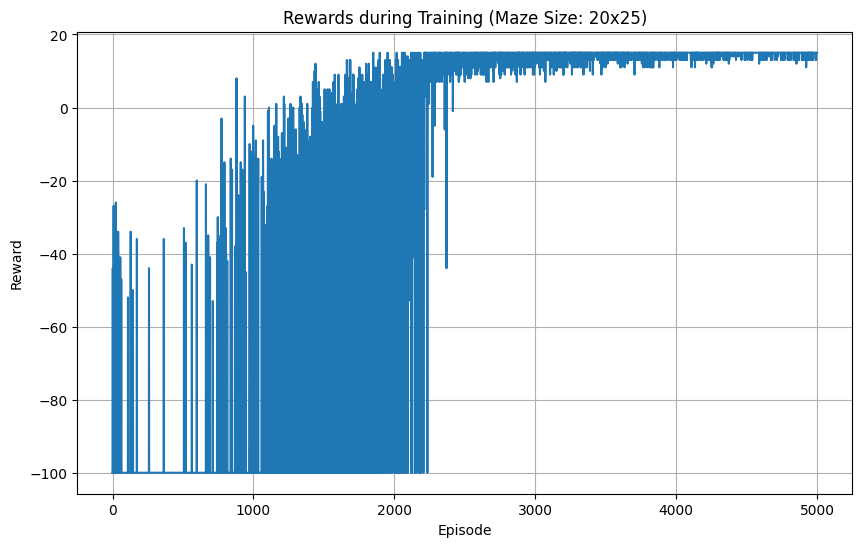

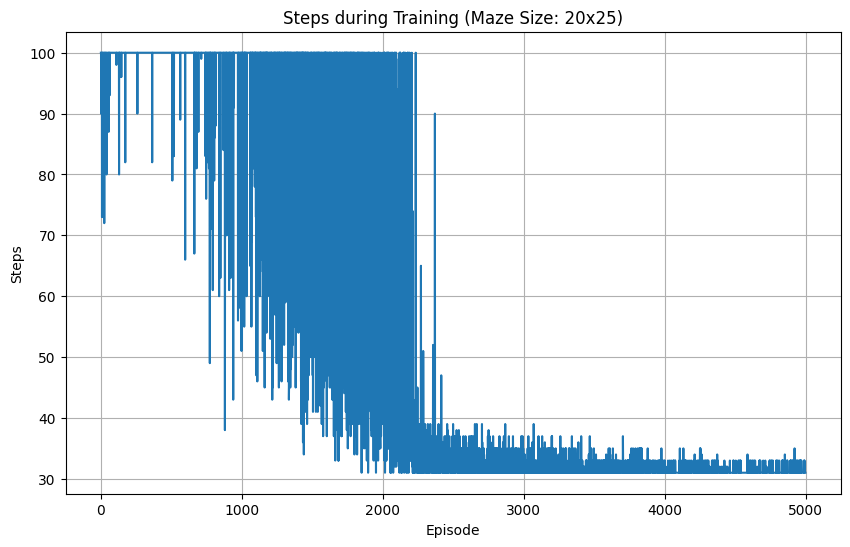

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
_____x______________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
___________________o

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
______x_____________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________

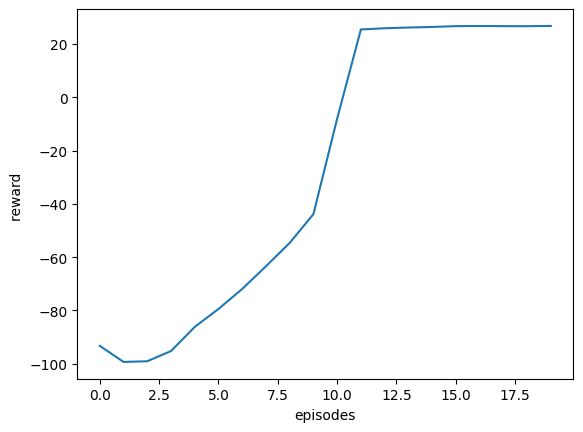

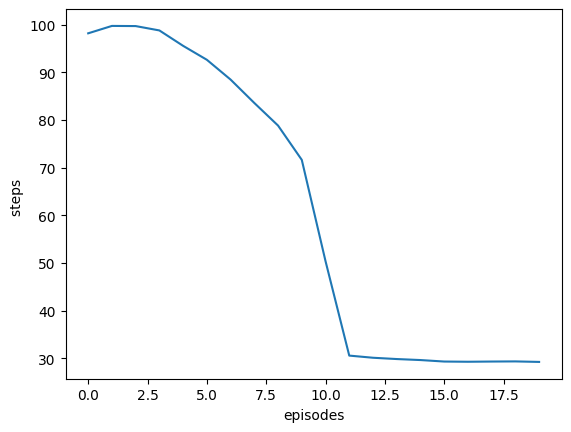

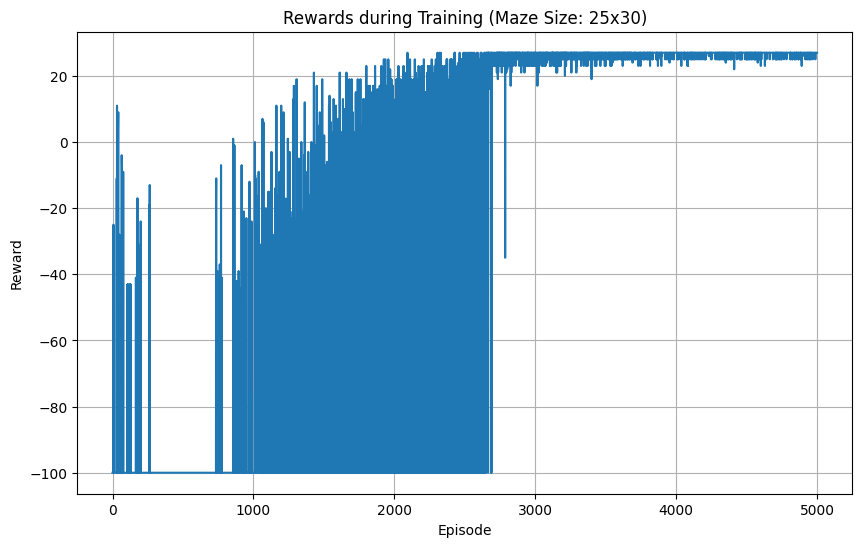

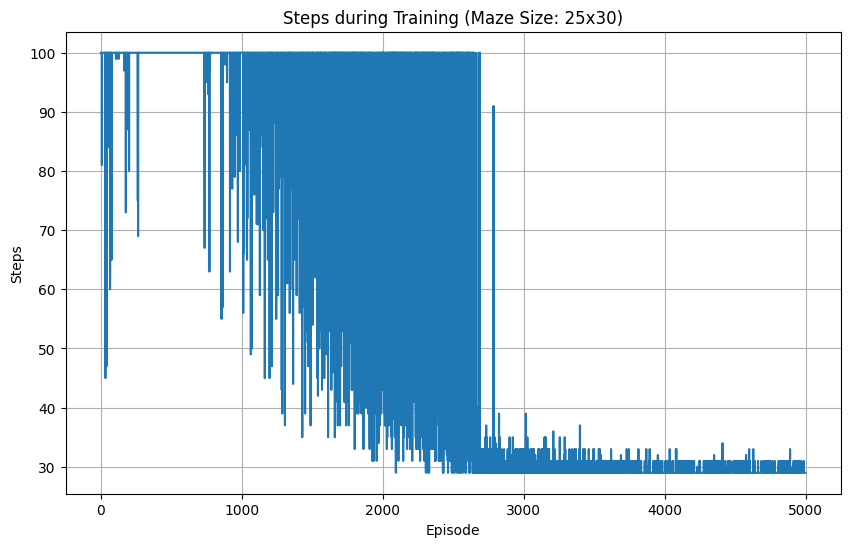

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________x_______________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
________________________o

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
___________

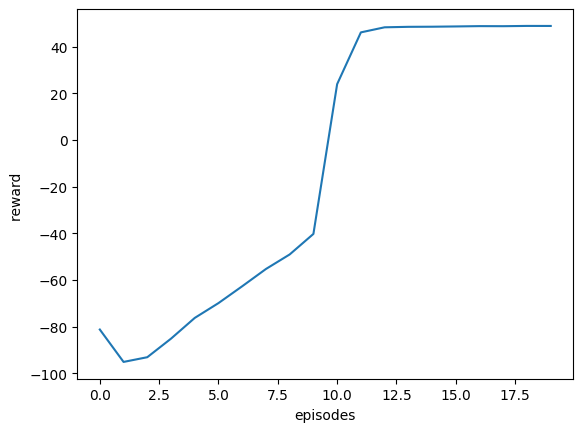

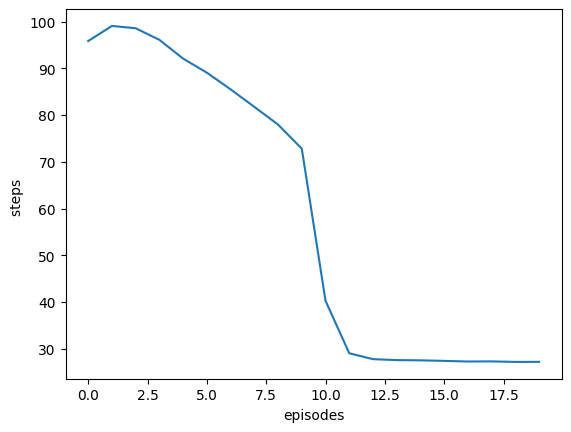

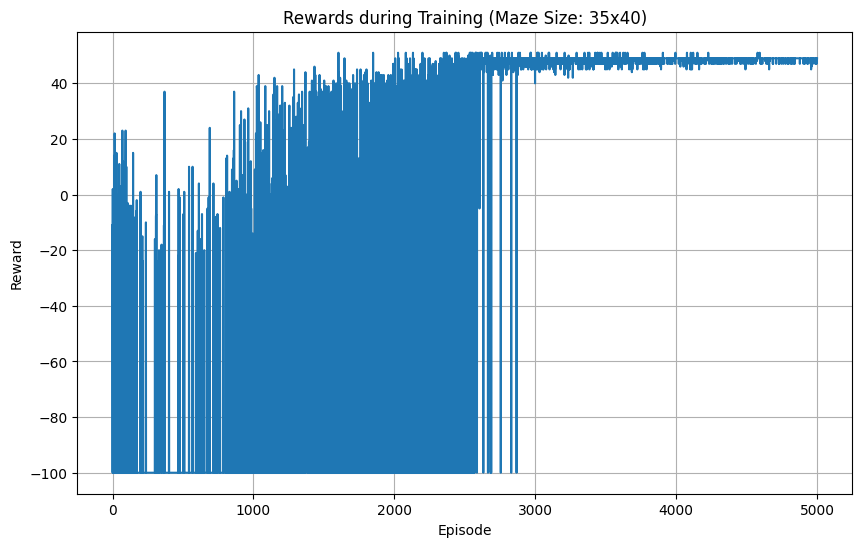

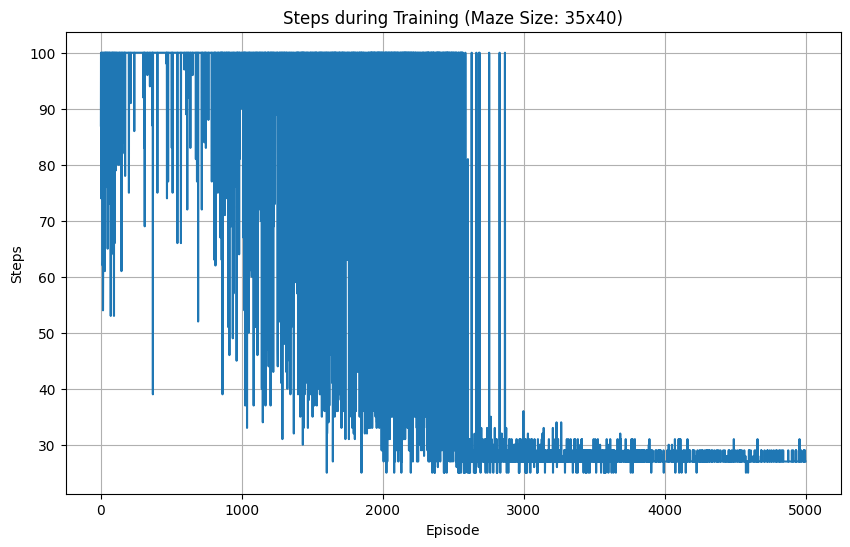

___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
____________________________

In [6]:

import matplotlib.pyplot as plt

# Define maze parameters
maze_params = [[10, 10], [15, 20], [20, 25], [25, 30], [35, 40]]  # Update maze sizes
start_points = [[0, 0], [2, 4], [4, 8], [8, 16], [16, 32]]  # Update start positions

# Loop through maze parameters
for i in range(len(maze_params)):
    # Create maze environment
    maze_height, maze_width = maze_params[i]
    start = start_points[i]
    maze = grid_env(maze_height, maze_width, start)

    # Create agent
    decay = 0.001

    epsilon = {'start': 1, 'min': 0.01, 'decay': decay}  # Update epsilon values as needed
    ag = agent(maze.n_states, eps=epsilon)  # Update other agent parameters as needed

    # Train agent
    episodes = 5000
    steps = 100
    [rewards, steps] = ag.train(maze, episodes, steps)

    display_learning(rewards, "reward ")
    display_learning(steps, "steps ")

    print(ag.Q_table)

    # Plot rewards and steps
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    # Test agent
    maze = grid_env(maze_height, maze_width, start, debug=True)
    test_agent_steps = ag.test_agent(maze)
    "Number of steps", test_agent_steps

    df = update_dataframe(df, steps, test_agent_steps, rewards, episodes, maze_height, maze_width, decay, start)


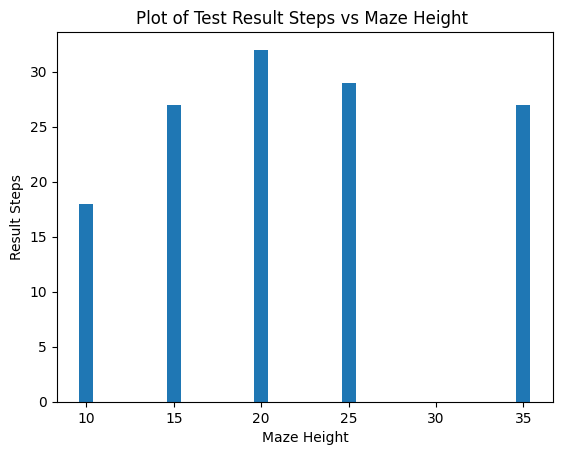

In [7]:
x = df['Maze Height']
y = df['Test Result Steps']

plt.bar(x, y)
plt.xlabel('Maze Height')
plt.ylabel('Result Steps')
plt.title('Plot of Test Result Steps vs Maze Height ')
plt.show()

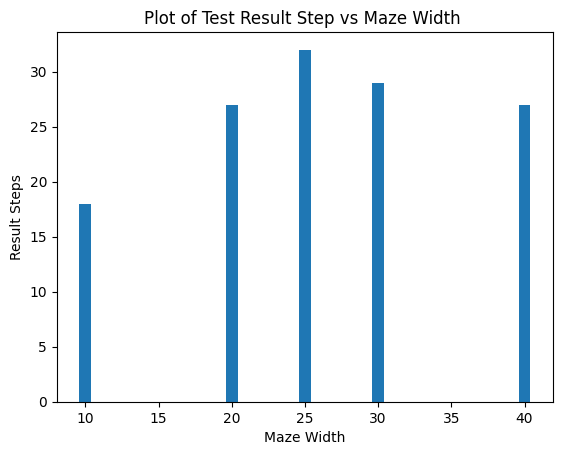

In [8]:
x = df['Maze Width']
y = df['Test Result Steps']

plt.bar(x, y)
plt.xlabel('Maze Width')
plt.ylabel('Result Steps')
plt.title('Plot of Test Result Step vs Maze Width ')
plt.show()

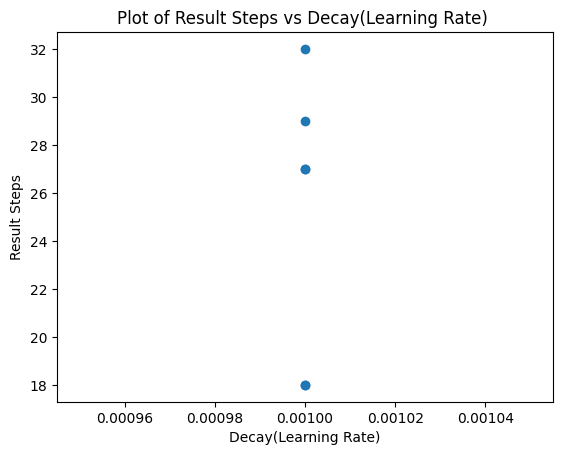

In [10]:
x = df['Decay(Learning Rate)']
y = df['Test Result Steps']

plt.scatter(x, y)
plt.xlabel('Decay(Learning Rate)')
plt.ylabel('Result Steps')
plt.title('Plot of Result Steps vs Decay(Learning Rate) ')
plt.show()

250  episodes  reward  -56.696
500  episodes  reward  -31.456
750  episodes  reward  -8.488
1000  episodes  reward  -5.292
1250  episodes  reward  -2.7
1500  episodes  reward  -0.812
1750  episodes  reward  -0.208
2000  episodes  reward  0.92
2250  episodes  reward  1.584
2500  episodes  reward  1.86
2750  episodes  reward  2.06
3000  episodes  reward  2.248
3250  episodes  reward  2.456
3500  episodes  reward  2.472
3750  episodes  reward  2.664
4000  episodes  reward  2.78
4250  episodes  reward  2.844
4500  episodes  reward  2.784
4750  episodes  reward  2.868
5000  episodes  reward  2.92


250  episodes  steps  71.648
500  episodes  steps  51.364
750  episodes  steps  29.488
1000  episodes  steps  26.292
1250  episodes  steps  23.7
1500  episodes  steps  21.812
1750  episodes  steps  21.208
2000  episodes  steps  20.08
2250  episodes  steps  19.416
2500  episodes  steps  19.14
2750  episodes  steps  18.94
3000  episodes  steps  18.752
3250  episodes  steps  18.544
3500  episodes  s

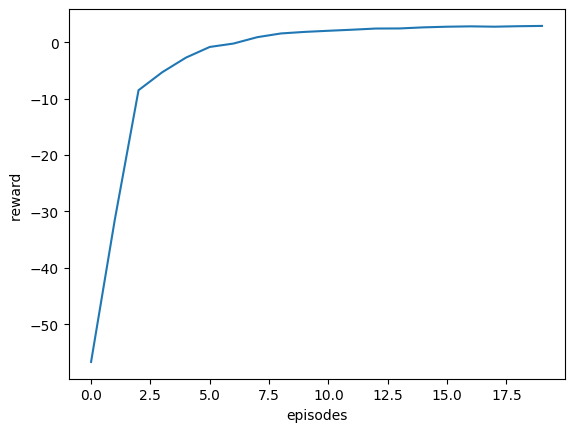

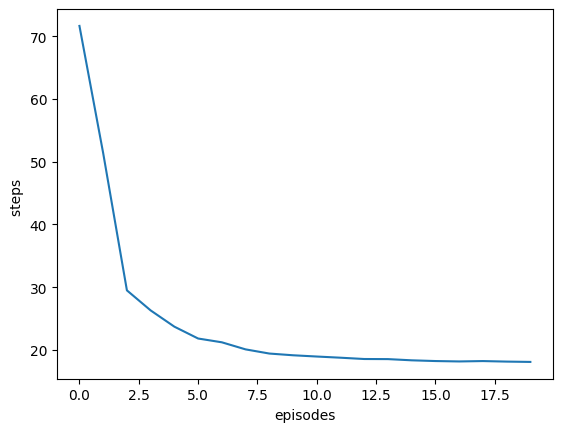

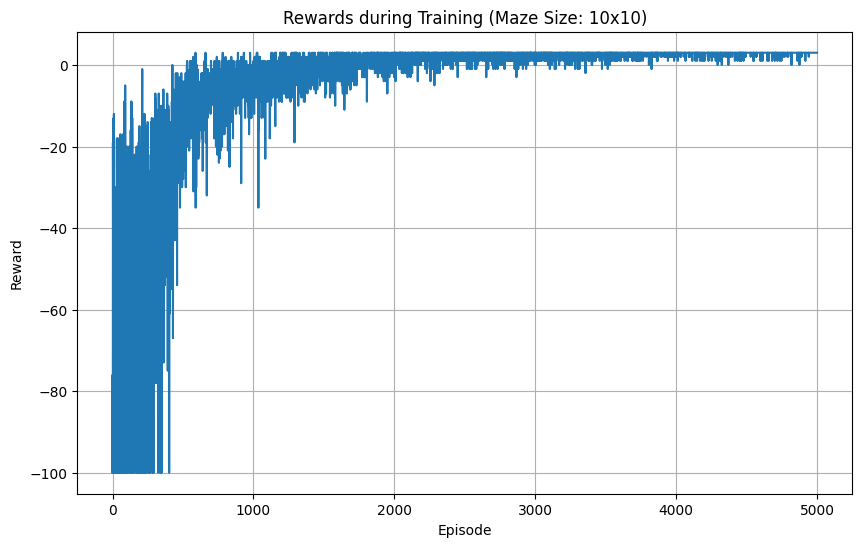

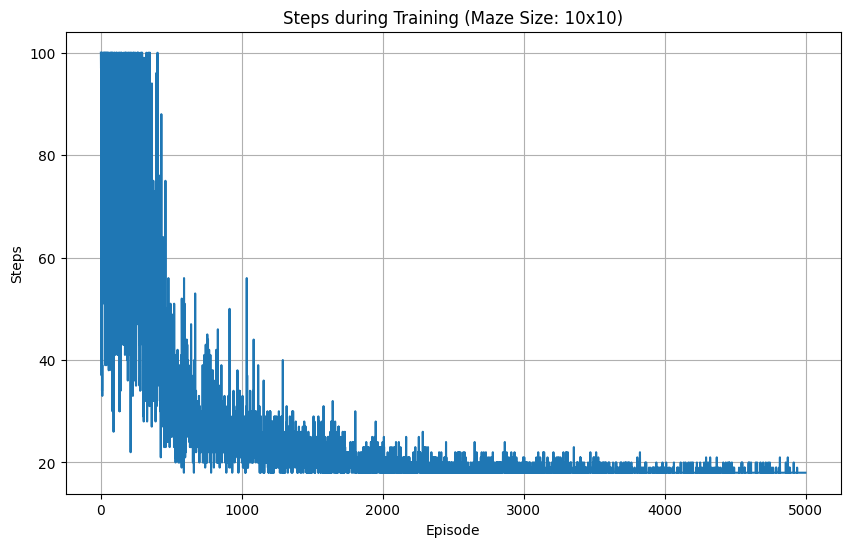

_x________
__________
__________
__________
__________
__________
__________
__________
__________
_________o

__x_______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

___x______
__________
__________
__________
__________
__________
__________
__________
__________
_________o

____x_____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_____x____
__________
__________
__________
__________
__________
__________
__________
__________
_________o

______x___
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_______x__
__________
__________
__________
__________
__________
__________
__________
__________
_________o

________x_
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_________x
__________
__________
__________
__________
__________
__________
__________
__________
_________o

_

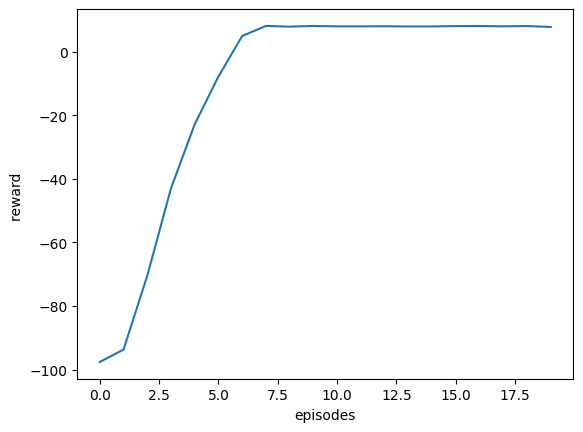

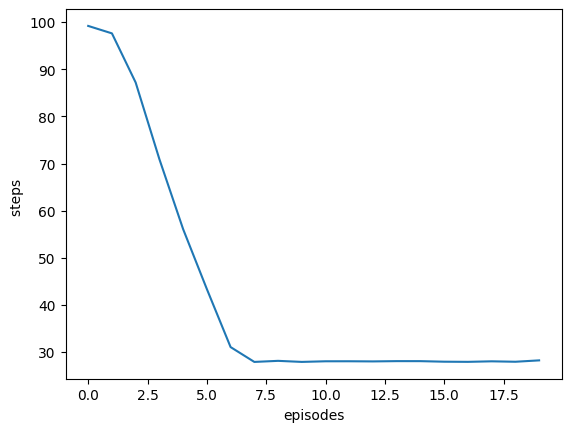

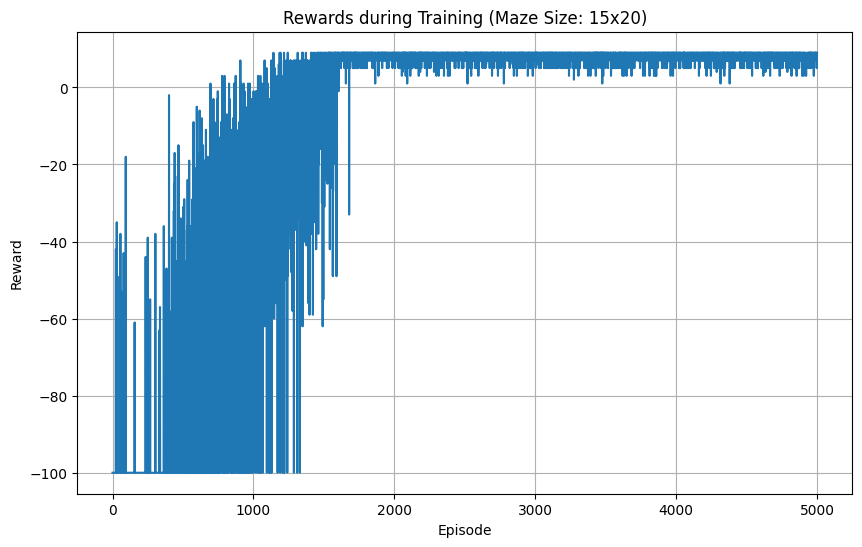

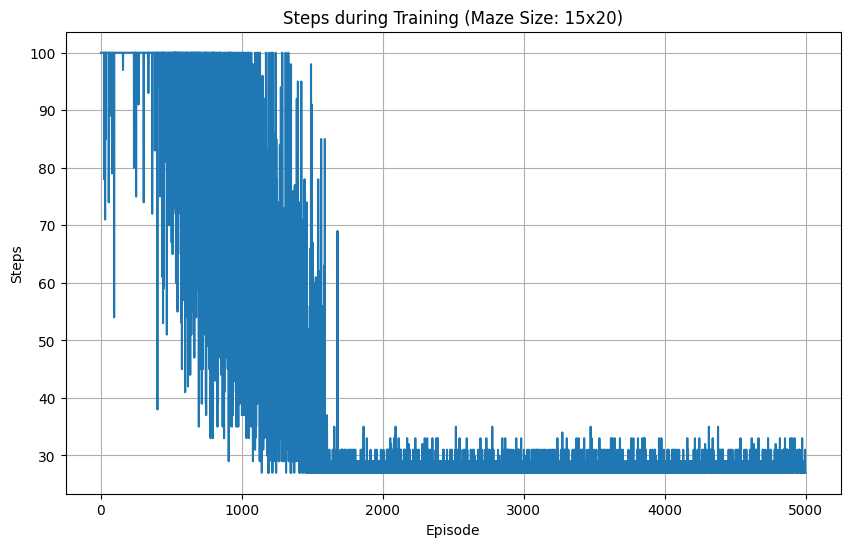

_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_______________
_______________
_______________
_______________
_______________
__x____________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
_______________
______________o

_______________
_______________
_____

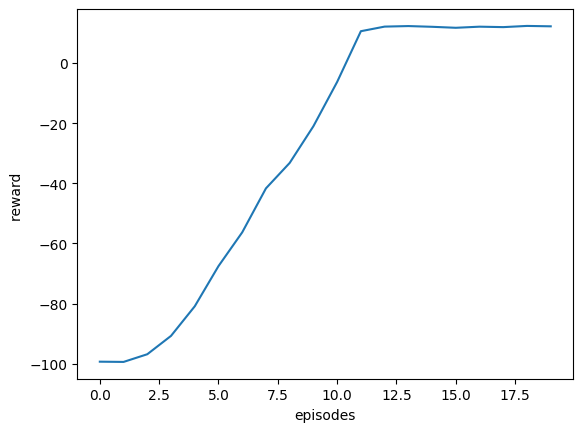

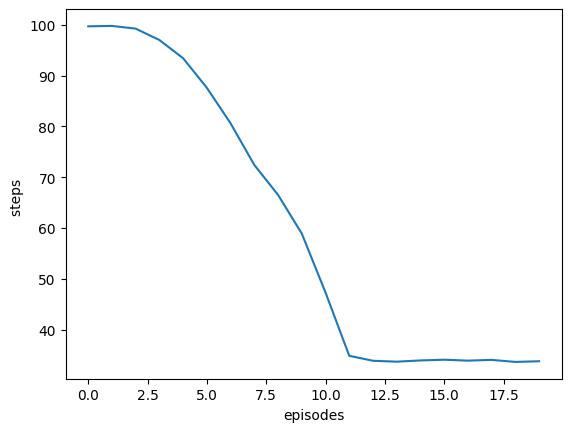

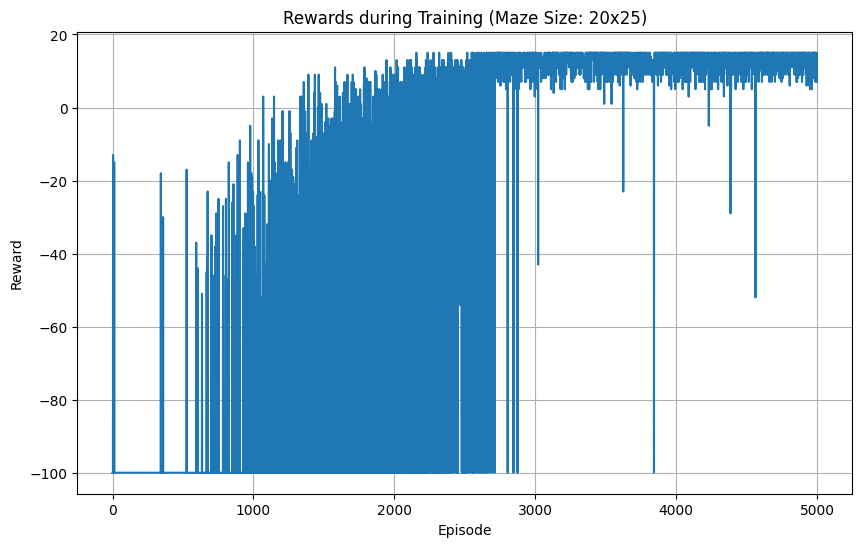

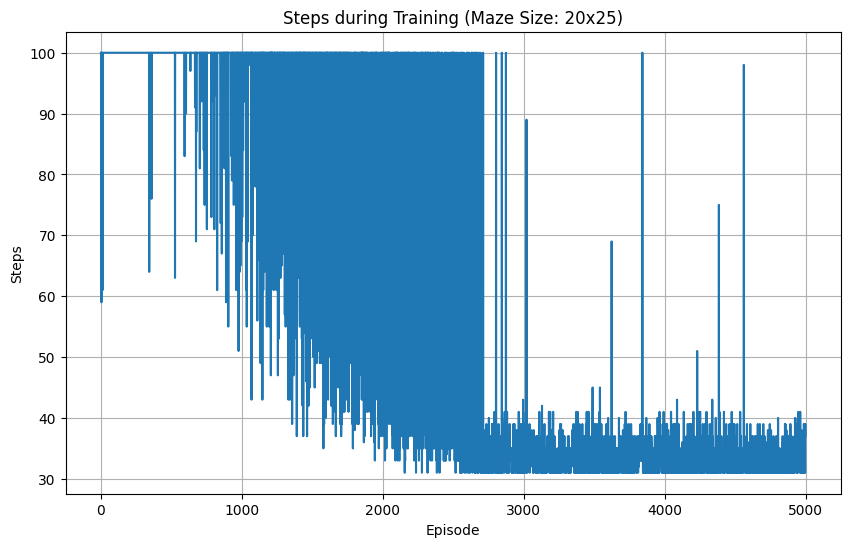

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____x_______________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
___________________o

____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____x_______________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________________
____________

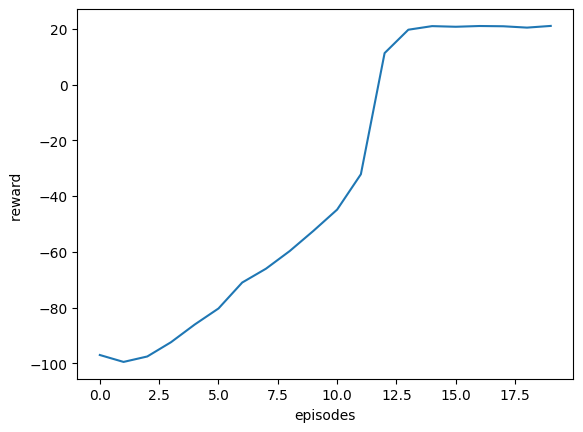

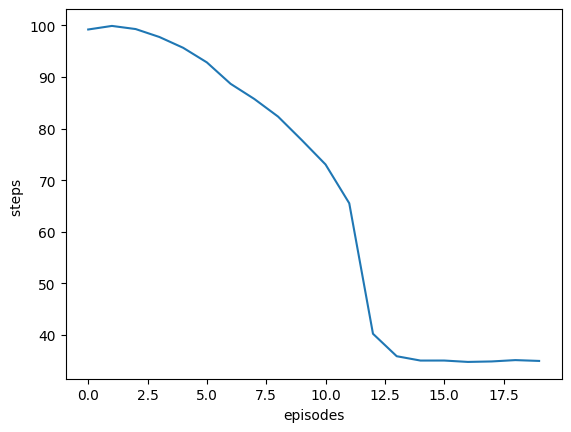

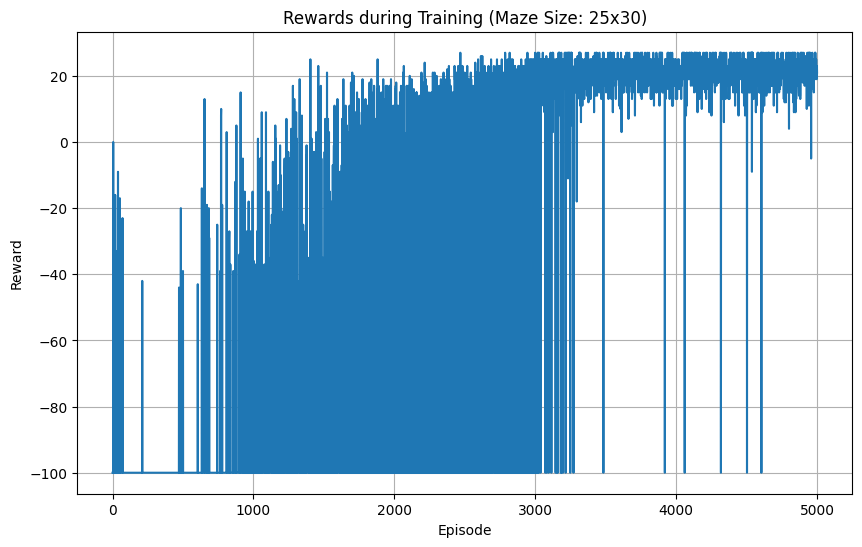

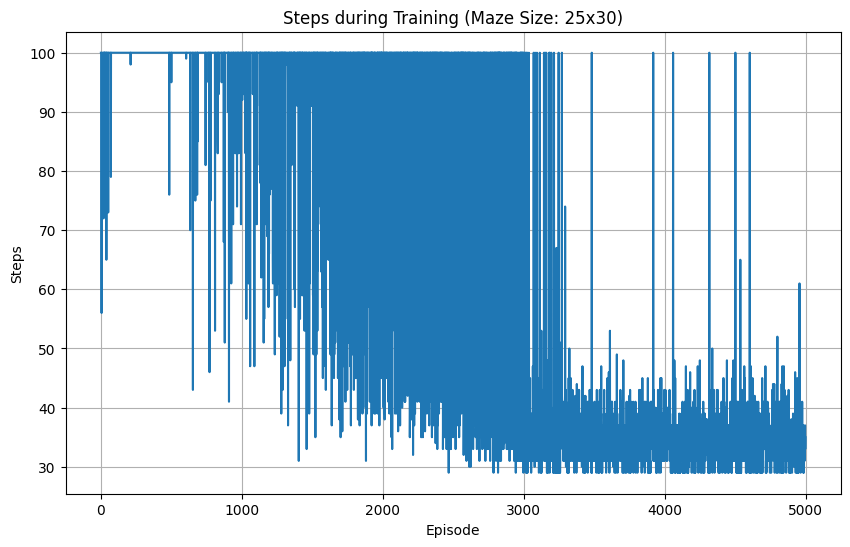

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________x_______________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
________________________o

_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
_________________________
___________

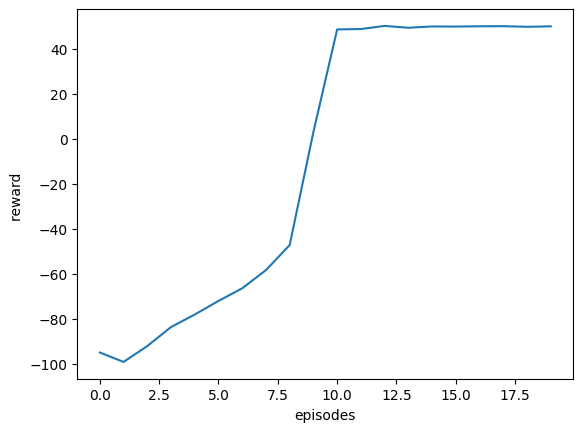

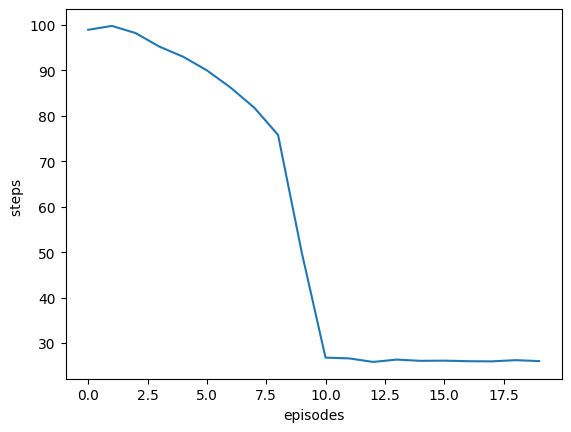

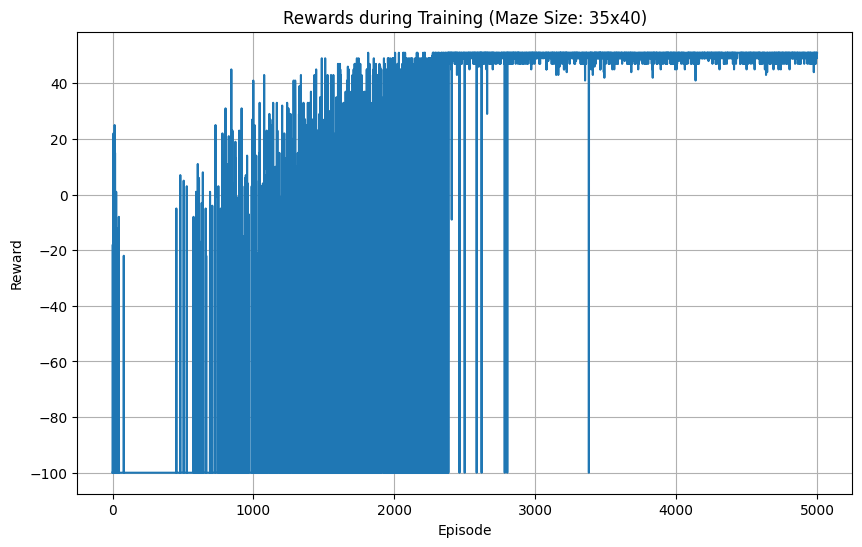

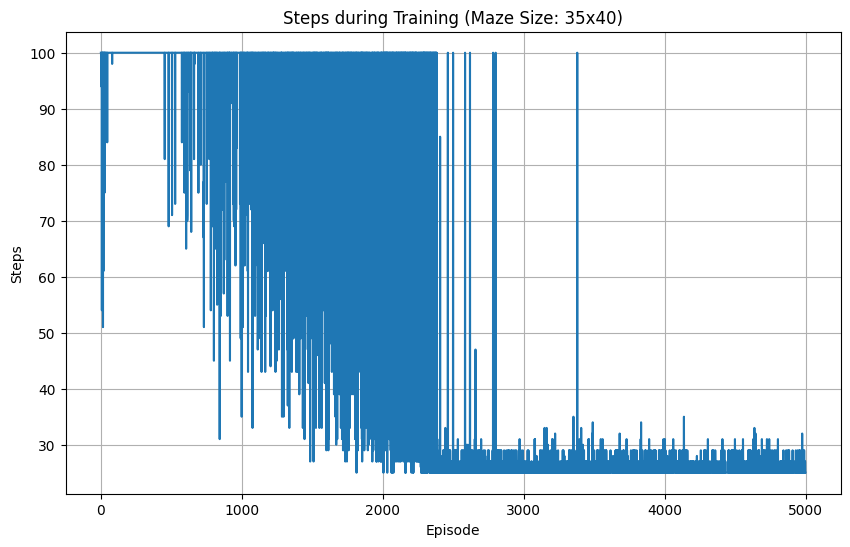

___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
___________________________________
____________________________

In [11]:
import matplotlib.pyplot as plt

# Define maze parameters
maze_params = [[10, 10], [15, 20], [20, 25], [25, 30], [35, 40]]  # Update maze sizes
start_points = [[0, 0], [2, 4], [4, 8], [8, 16], [16, 32]]  # Update start positions

# Define epsilon values
epsilon_values = [
    {'start': 1, 'min': 0.01, 'decay': 0.001},
    {'start': 0.8, 'min': 0.05, 'decay': 0.002},
    {'start': 0.5, 'min': 0.1, 'decay': 0.003},
    {'start': 0.3, 'min': 0.2, 'decay': 0.004},
    {'start': 0.2, 'min': 0.04, 'decay': 0.005}
]

# Loop through maze parameters
for i in range(len(maze_params)):
    # Create maze environment
    maze_height, maze_width = maze_params[i]
    start = start_points[i]
    maze = grid_env(maze_height, maze_width, start)

    # Create agent
    epsilon = epsilon_values[i]
    #epsilon = {'start': 1, 'min': 0.01, 'decay': 0.001}  # Update epsilon values as needed
    learning_rate = 0.1  # Update learning rate as needed
    discount_factor = 0.9  # Update discount factor as needed
    ag = agent(maze.n_states, eps=epsilon, learning_rate=learning_rate,
               discount=discount_factor)  # Update agent parameters as needed

    # Train agent
    episodes = 5000
    steps = 100
    [rewards, steps] = ag.train(maze, episodes, steps)
    display_learning(rewards, "reward ")
    display_learning(steps, "steps ")

    print(ag.Q_table)

    # Plot rewards and steps
    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps during Training (Maze Size: {}x{})'.format(maze_height, maze_width))
    plt.grid(True)
    plt.show()

    # Test agent
    maze = grid_env(maze_height, maze_width, start, debug=True)
    test_agent_steps = ag.test_agent(maze)
    print("Number of steps: ", test_agent_steps)
    df = update_dataframe(df, steps, test_agent_steps, rewards, episodes, maze_height, maze_width, epsilon['decay'], start)


A. Modify the maze, changing size and shape, and different start positions. How many steps does it take to reach the target? Does the performance vary as you expect?

Episodes	Maze Height	Maze Width	Test Result Steps
5000	10	10	18
5000	10	10	18
5000	15	20	27
5000	20	25	31
5000	25	30	29
5000	35	40	27

As shown the table, there are variations in steps with changes in the maze height and width.

B.	Change the agent learning parameters (e.g. learning rate, discount factor, exploration values). How does performance change in terms of learning speed and ability to reach the target? What happens if exploration is always maximum? And if it decreases very quickly?


Episode

As the number of episodes increases in reinforcement learning, the number of steps taken by the agent to reach a reward typically decreases. This is because with more iterations, the agent has more opportunities to explore the environment, learn from its actions, and adjust its policy accordingly. This can result in a better policy that leads to higher rewards over time. By exploring the environment more thoroughly, the agent can learn the underlying dynamics of the environment and identify the most effective actions to take. With each iteration, the agent refines its policy and improves its ability to achieve its objectives. Therefore, increasing the number of iterations is a crucial aspect of the reinforcement learning process, as it enables the agent to gradually optimize its performance and reach its full potential.

Decay (Learning Rate)

The learning rate is an important hyperparameter in machine learning algorithms, including reinforcement learning. When the learning rate is set too high, it can lead to overfitting of the model. This can happen because the model is too sensitive to noise in the data and is fitting the noise rather than the underlying pattern. As a result, the model may perform well on the training data but have a lower performance on the test data.
In reinforcement learning, a higher learning rate can cause the agent to make more drastic updates to its policy based on the most recent experience, which can lead to unstable and unpredictable behavior. This can result in the agent overfitting to the training data and performing poorly on new data.
In contrast, a lower learning rate can result in slower convergence of the learning process, but can help the agent to generalize better to new environments and perform better on test data.
Therefore, it is important to choose an appropriate learning rate for the problem at hand and to monitor the performance of the agent on both training and test data to ensure that it is not overfitting. By selecting a suitable learning rate, we can optimize the performance of the agent and ensure that it can effectively learn from its experiences and make accurate predictions in new situations.
